In [12]:
import numpy as np 
from matplotlib import pyplot as plt

np.random.seed(0)

# Initialize an environment

# Each user is a context
# Each user is denoted by his/her index (ex: user 0 or user 3)
num_users = 5 

# Each advertisment is an action
num_ads = 10 # There are 10 ads 
epsilon = 0.1

# reward_table is a dictionary of key: the index of a user / value: np.array of the deterministic reward of each action (ad)
reward_table = {user: np.random.choice(10, size=num_ads) for user in range(num_users)}

In [2]:
reward_table

{0: array([5, 0, 3, 3, 7, 9, 3, 5, 2, 4]),
 1: array([7, 6, 8, 8, 1, 6, 7, 7, 8, 1]),
 2: array([5, 9, 8, 9, 4, 3, 0, 3, 5, 0]),
 3: array([2, 3, 8, 1, 3, 3, 3, 7, 0, 1]),
 4: array([9, 9, 0, 4, 7, 3, 2, 7, 2, 0])}

In [3]:
class UniformlyRandom:
    def __init__(self, num_actions):
        """
        num_actions: number of actions (in this demo, it is equal to the number of ads)
        """
        self.num_actions = num_actions 

    def choose_action(self, context ):
        """
        return a chosen action and action-probabilities
        """
        return np.random.choice(self.num_actions), [1 / self.num_actions] * self.num_actions

    def update(self, cb_sample):
        """
        UniformlyRandom is a stateless policy, which means it does not update itself
        based on the past rewards revelaed by it.
        (parameters)
        cb_sample: a tuple of (context, chosen action, reward revealed)
        """
        pass

In [4]:
class EpsilonGreedy:
    def __init__(self, num_actions, num_contexts, epsilon=0.1):
        """
        This is a CB verision of epsilon greedy
        (parameters)
        num_actions: number of actions (= number of ads)
        num_contexts: number of contexts (= number of users)
        epsilon: this policy chooeses a random action with epsilon probability 
        (Stored values)
        self.num_actions = num_actions 
        self.num_contexts = num_contexts
        self.num_actions_chosen: keep track of how many times each action is chosen for each context
        self.sum_rewards: keep track of the total reward of each action for each context
        The reason why self.num_actions_chosen is initialized with np.ones instead of np.zeros is
        to prevent division by zero in the function choose_action (line 68) 
        when an action has never been chosen so far for a given context.
        """
        self.num_actions = num_actions 
        self.num_contexts = num_contexts
        self.num_actions_chosen = {context: np.ones(num_actions) for context in range(num_contexts)}
        self.sum_rewards = {context: np.zeros(num_actions) for context in range(num_contexts)}
        self.epsilon = epsilon

    def choose_action(self, context):
        """
        return a chosen action and its probability
        """
        # Check which action is the best action 
        # The best action is the action that has the highest total reward for a given context
        best_action = np.argmax(self.sum_rewards[context] / self.num_actions_chosen[context])

        # Get action probabilities based on the best action
        # there is a (epsilon + epsilon/num_actions) probability of choosing the best action.
        # there is a (epsilon/num_actions) probability of choosing any other action
        action_probabilities = [self.epsilon / self.num_actions] * self.num_actions
        action_probabilities[best_action] += 1 - self.epsilon

        # Sample an action
        chosen_action = np.random.choice(self.num_actions, p=action_probabilities)

        # Record the number of times the chosen action is chosen
        self.num_actions_chosen[context][chosen_action] += 1

        return chosen_action, action_probabilities

    def update(self, cb_sample):
        """
        EpsilonGreedy is a stateful policy, which means it does update itself
        based on the past rewards revelaed by it.
        Thus, update function is necessary.
        (parameters)
        cb_sample: a tuple of (context, chosen action, reward revealed)
        """
        context, chosen_action, reward_revealed = cb_sample

        self.sum_rewards[context][chosen_action] += reward_revealed

In [5]:
class IPS:
    def __init__(self, trace):
        self.trace = trace
    
    def estimate(self):
        n = len(self.trace)
        total = 0
        for round_ in self.trace:
            user, action, old_p, new_p, r = round_
            total += new_p / old_p * r
        
        return total/n

In [6]:
# Implement IPS 
class IPS:
    def __init__(self):
        self.estimates = list()

    def get_estimate(self, old_p, new_p, r):
        """
        Append the IPS estimate of a single sample to self.estimates.
        You should implement this function
        """
        self.estimates.append(new_p/old_p*r)

    def evaluation(self, num_samples):
        """
        Get the mean of num_samples number of IPS estimates
        """
        return np.mean(self.estimates[:num_samples])

In [7]:
class StochasticPolicy:
    def __init__(self, num_actions):
        self.num_actions = num_actions

    def choose_action(self, context):
        '''
        Always chooses the first ad
        '''
        return (0, [1] + [0] * (self.num_actions - 1))

    def update(self, cb_sample):
        pass

In [8]:
class DeterministicPolicy:
    def __init__(self, num_actions):
        self.num_actions = num_actions

    def choose_action(self, context):
        '''
        Always chooses from ratio of 1:2:1:2:1:2 ... 
        '''
        p = np.ones(self.num_actions)
        for i in range(self.num_actions):
            if i % 2 == 1:
                p[i] = 2
        p = p/np.sum(p)
        chosen_action = np.random.choice(self.num_actions, p=p)
        
        return chosen_action, p

    def update(self, cb_sample):
        pass

In [46]:
def run_experiment(old_policy, new_policy):
    epsilon = 0.1 # epsilon is a tunable parameter
    data = list()

    # Start the demo
    num_samples = 1000000 # total number of samples. Feel free to change this if you want to
    new_policy_true_rewards = list() # Keep track of true rewards revealed by the new policy

    # Implement the demo as specified by the comments below
    ips_estimator = IPS()

    for sample_index in range(num_samples): 
        # Context (user) revealed
        user = np.random.choice(num_users)

        # The old policy chooses an action
        old_chosen_action, old_probabilities = old_policy.choose_action(user)

        # The reward of the action chosen by the old policy is revealed
        reward = reward_table[user][old_chosen_action]

        # The new policy chooses an action
        new_chosen_action, new_probabilities = new_policy.choose_action(user)

        # Record the reward revealed by the new policy to get the true performance of the new policy
        new_policy_true_rewards.append(reward_table[user][new_chosen_action])

        # Store the CB sample in trace for evaluation
        ips_estimator.get_estimate(old_probabilities[old_chosen_action], new_probabilities[old_chosen_action],
                                  reward)

        # Update the old policy if needed
        old_policy.update((user, old_chosen_action, reward))
    
    true_performance = np.mean(new_policy_true_rewards)
    n_samples = np.array([10]*6)**range(1, 7)
    ips_estimates = np.zeros((6, 20))
    for i in range(20):
        boot = np.random.choice(range(num_samples), num_samples)
        boot_estimates = np.array(ips_estimator.estimates)[boot]
        for j in range(6):
            ips_estimates[j, i] = np.mean(boot_estimates[:n_samples[j]])
    mean_err = np.mean(np.abs(true_performance - 
                        ips_estimates)/true_performance, axis=1)
    std = np.std(np.abs(true_performance - ips_estimates)/true_performance, axis=1)
        
    plt.plot(n_samples, mean_err)
    plt.errorbar(n_samples, mean_err, yerr = std)
    plt.title('mean error')
    plt.xscale('log')
    plt.show()
    

In [13]:
uni_ran = UniformlyRandom(num_ads)
eps_greedy = EpsilonGreedy(num_ads, num_users, epsilon=epsilon)
sto = StochasticPolicy(num_ads)
det = DeterministicPolicy(num_ads)

Experiment 2

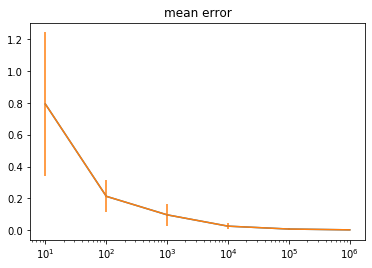

In [50]:
run_experiment(uni_ran, sto)

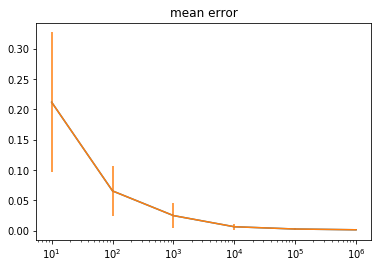

In [47]:
run_experiment(uni_ran, det)

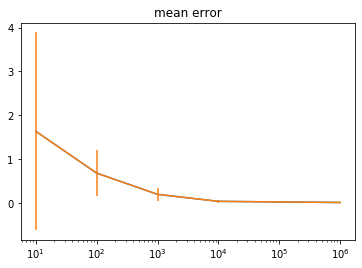

In [48]:
run_experiment(eps_greedy, sto)

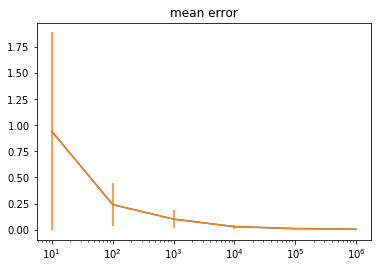

In [49]:
run_experiment(eps_greedy, det)